[Reference](https://www.kaggle.com/code/tingsongou/finetuning-fasterrcnn-for-mask-detection-pytorch)

[FastRCNN Predictor](https://towardsdatascience.com/understanding-and-implementing-faster-r-cnn-a-step-by-step-guide-11acfff216b0)

[Pytorch Reference](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html)

## Imports

In [1]:
import os
from PIL import Image
import numpy as np

# # Pytorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision

from bs4 import BeautifulSoup

# Plotting
from matplotlib import pyplot as plt
from matplotlib import patches

from tqdm import tqdm
import time

/opt/homebrew/Caskroom/miniforge/base/envs/ml_proj/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Initialize Parameters

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
curr_dir = os.getcwd()
curr_dir

'/Users/weiming/Dev/Personal_Projects/Personal_Projects/mask_detection_pytorch'

In [4]:
img_dir = os.path.join(curr_dir, "./data/images/")
annot_dir = os.path.join(curr_dir, "./data/annotations/")

imgs_list = list(sorted(os.listdir(img_dir)))
annotations_list = list(sorted(os.listdir(annot_dir)))

print(f"Total files: {len(imgs_list)}")

Total files: 853


## Inspect Data

In [5]:
# Inspect bounding boxes

with open(annot_dir + annotations_list[0], "r") as f:
    data = f.read()
    
    soup = BeautifulSoup(data, "xml")
    # Find all objects
    objs = soup.find_all("object")
    # Get the number of objects in the image
    num_objs = len(objs)
    print(num_objs)
    
    bounding_box = []
    labels = []
    
    for obj in objs:
        # Get the corners of each bounding box
        x_min = int(obj.find("xmin").text)
        y_min = int(obj.find("ymin").text)
        x_max = int(obj.find("xmax").text)
        y_max = int(obj.find("ymax").text)
        
        # Set the corners
        corners = [x_min, y_min, x_max, y_max]
        bounding_box.append(corners)
        
        # Get the labels
        lbl = obj.find("name").text
        if lbl == "with_mask": labels.append(1)
        if lbl == "mask_weared_incorrect": labels.append(2)
        if lbl == "without_mask": labels.append(0)
        
        print(x_min, y_min, x_max, y_max)

3
79 105 109 142
185 100 226 144
325 90 360 141


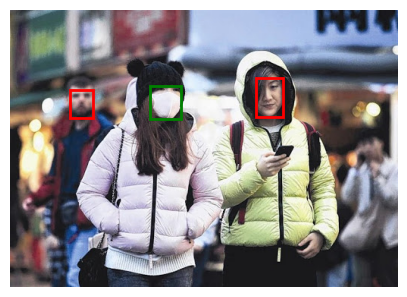

In [6]:
img_dir + imgs_list[0]
test_img = Image.open(img_dir + imgs_list[0])
fig, ax = plt.subplots(1, figsize=(5, 5))
ax.imshow(test_img)

for index, box in enumerate(bounding_box):
    x_min, y_min, x_max, y_max = box
    color = ""
    if labels[index] == 0: color = "r"
    if labels[index] == 1: color = "g"
    if labels[index] == 2: color = "b"
    
    rect = patches.Rectangle([x_min, y_min], x_max - x_min, y_max - y_min, linewidth=2,edgecolor=color, facecolor="none")

    ax.axis(False)
    ax.add_patch(rect)

In [7]:
objs

[<object>
 <name>without_mask</name>
 <pose>Unspecified</pose>
 <truncated>0</truncated>
 <occluded>0</occluded>
 <difficult>0</difficult>
 <bndbox>
 <xmin>79</xmin>
 <ymin>105</ymin>
 <xmax>109</xmax>
 <ymax>142</ymax>
 </bndbox>
 </object>,
 <object>
 <name>with_mask</name>
 <pose>Unspecified</pose>
 <truncated>0</truncated>
 <occluded>0</occluded>
 <difficult>0</difficult>
 <bndbox>
 <xmin>185</xmin>
 <ymin>100</ymin>
 <xmax>226</xmax>
 <ymax>144</ymax>
 </bndbox>
 </object>,
 <object>
 <name>without_mask</name>
 <pose>Unspecified</pose>
 <truncated>0</truncated>
 <occluded>0</occluded>
 <difficult>0</difficult>
 <bndbox>
 <xmin>325</xmin>
 <ymin>90</ymin>
 <xmax>360</xmax>
 <ymax>141</ymax>
 </bndbox>
 </object>]

In [8]:
annotations_list[0]

'maksssksksss0.xml'

In [9]:
annot_dir

'/Users/weiming/Dev/Personal_Projects/Personal_Projects/mask_detection_pytorch/./data/annotations/'

In [10]:
soup

<?xml version="1.0" encoding="utf-8"?>
<annotation>
<folder>images</folder>
<filename>maksssksksss0.png</filename>
<size>
<width>512</width>
<height>366</height>
<depth>3</depth>
</size>
<segmented>0</segmented>
<object>
<name>without_mask</name>
<pose>Unspecified</pose>
<truncated>0</truncated>
<occluded>0</occluded>
<difficult>0</difficult>
<bndbox>
<xmin>79</xmin>
<ymin>105</ymin>
<xmax>109</xmax>
<ymax>142</ymax>
</bndbox>
</object>
<object>
<name>with_mask</name>
<pose>Unspecified</pose>
<truncated>0</truncated>
<occluded>0</occluded>
<difficult>0</difficult>
<bndbox>
<xmin>185</xmin>
<ymin>100</ymin>
<xmax>226</xmax>
<ymax>144</ymax>
</bndbox>
</object>
<object>
<name>without_mask</name>
<pose>Unspecified</pose>
<truncated>0</truncated>
<occluded>0</occluded>
<difficult>0</difficult>
<bndbox>
<xmin>325</xmin>
<ymin>90</ymin>
<xmax>360</xmax>
<ymax>141</ymax>
</bndbox>
</object>
</annotation>

In [11]:
annotations_list[0]

'maksssksksss0.xml'

## Dataset and DataLoader

In [12]:
# Helper functions
def get_img(img_file, transforms) ->torch.Tensor:
    # img_dir = img_dir
    img = Image.open(img_dir + img_file).convert("RGB")
    return transforms(img)

In [13]:
def get_annotation(annot_file:str)->dict:
    """Generates a dictionary of annotations with bounding box and label info.

    Args:
        annot_dir (str): Folder of annotations
        annot_file (str): Annotation filename e.g. maksssksksss0.xml

    Returns:
        dict: Dictionary of annotation information with bounding boxes
    """
    # annot_dir = annot_dir
    with open(annot_dir + annot_file, "r") as f:
        data = f.read()
        soup = BeautifulSoup(data, "xml")
        objects = soup.find_all("object")
        # num_objs = len(objects)
        
        bboxes, labels, img_id = [], [], 0
        
        # Get the corners
        for obj in objects:
            x_min = int(obj.find("xmin").text)
            y_min = int(obj.find("ymin").text)
            x_max = int(obj.find("xmax").text)
            y_max = int(obj.find("ymax").text)
            
            corners = [x_min, y_min, x_max, y_max]
            bboxes.append(corners)
            
            
            # Get labels
            # Note: fasterRCNN, 0 is designated for background
            # Labels index should start from 1
            label = obj.find("name").text
            if label == "with_mask": labels.append(1)
            if label == "mask_weared_incorrect": labels.append(2)
            if label == "without_mask": labels.append(3)
            
            # Get image ID
            # maksssksksss100.xml -> 100
            img_id = int(annot_file.split(".")[0][12:])
            
    return {
        "boxes": torch.tensor(bboxes),
        "labels": torch.LongTensor(labels),
        "img_id": torch.LongTensor(img_id)
    }

In [14]:
# Include transformation (Can be initialized separately or within the class)
transformations = transforms.Compose([
    transforms.ToTensor(),
])

In [15]:
class MaskDataset(Dataset):
    def __init__(self, img_files, annotated_files, transforms):
        
        self.img_files = img_files
        self.annot_files = annotated_files
        self.length = len(self.img_files)
        
        # Convert to RGB first then to tensor
        self.imgs = [get_img(self.img_files[i], transforms) for i in range(self.length)]
        self.targets = [get_annotation(annotated_files[i]) for i in range(self.length)]
    
    def __len__(self):
        return self.length
    
    def __getitem__(self, index):
        return self.imgs[index], self.targets[index]
    

In [16]:
# Initialize Mask Dataset
mask_dataset = MaskDataset(imgs_list, annotations_list, transformations)

In [17]:
# Inspect the output of the first image
mask_dataset[0]

(tensor([[[0.4431, 0.4314, 0.3843,  ..., 0.1569, 0.2824, 0.3373],
          [0.4118, 0.3882, 0.3451,  ..., 0.1529, 0.1882, 0.3098],
          [0.3765, 0.3569, 0.3255,  ..., 0.1490, 0.1216, 0.2784],
          ...,
          [0.3333, 0.3412, 0.3569,  ..., 0.1098, 0.1098, 0.1137],
          [0.3373, 0.3490, 0.3608,  ..., 0.1137, 0.1137, 0.1176],
          [0.3647, 0.3765, 0.3922,  ..., 0.1176, 0.1176, 0.1216]],
 
         [[0.4353, 0.4235, 0.3765,  ..., 0.2314, 0.3843, 0.4549],
          [0.3922, 0.3804, 0.3373,  ..., 0.2275, 0.2863, 0.4275],
          [0.3608, 0.3412, 0.3098,  ..., 0.2235, 0.2235, 0.3922],
          ...,
          [0.3255, 0.3333, 0.3490,  ..., 0.1059, 0.1059, 0.1098],
          [0.3294, 0.3412, 0.3529,  ..., 0.1098, 0.1098, 0.1137],
          [0.3569, 0.3686, 0.3843,  ..., 0.1137, 0.1137, 0.1176]],
 
         [[0.4549, 0.4431, 0.3961,  ..., 0.4000, 0.6157, 0.7294],
          [0.4157, 0.3922, 0.3490,  ..., 0.3843, 0.5059, 0.6784],
          [0.3647, 0.3451, 0.3137,  ...,

In [18]:
# DataLoaders
def collate_fn(batch):
    return tuple(zip(*batch))

### Split Data

In [19]:
training_pct = 0.8

training_size = int(len(mask_dataset) * training_pct)
test_size = len(mask_dataset) - training_size

train_data, test_data = random_split(mask_dataset, [training_size, test_size])

### DataLoaders

In [20]:
train_loader = DataLoader(train_data, batch_size=32, num_workers=0, shuffle=True ,collate_fn=collate_fn)

## Define Model

In [21]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# Define number of classes (Our own dataset)
# Background + 3 masking classes
num_classes = 4

# Input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# Replace pre-trained head with a new head
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model = model.to(device)

/opt/homebrew/Caskroom/miniforge/base/envs/ml_proj/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ml_proj/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [22]:
# Additional Model Information:

# for param in model.parameters():
#     param.requires_grad = False

# Ref: https://pytorch.org/tutorials/intermediate/torchvision_tutorial
# Construct an optimizer:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=1e-4, amsgrad=True, weight_decay=1e-6)

# Add scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

## Define Training Loop

In [23]:
def train(model, dataloader, optimizer):
    
    # Set model to training mode
    model.train()
    train_loss = 0
    
    # Add a tqdm bar to show training progress
    batch_bar = tqdm(total=len(dataloader), position=0, leave=False, dynamic_ncols=True, desc="Train")
    
    for i, (images, targets) in enumerate(dataloader):
                
        # Get the images:
        images = list([image.to(device) for image in images])
        targets = [{k:v.to(device) for k, v in t.items()} for t in targets]
        
        # Generate a loss dictionary as it returns multiple values for multi-classification in a single image
        loss_dict = model(images, targets)
        loss = sum(loss_dict.values())
        
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        # Update tqdm bar information
        batch_bar.set_postfix(
            loss = f"{train_loss / (i+1):.4f}",
            lr = f"{optimizer.param_groups[0]['lr']:.6f}"
        )
        batch_bar.update()
    batch_bar.close()
    return train_loss/len(dataloader)
        

In [24]:
# Training
for i in range(1):
    start_time = time.time()
    
    train_loss = train(model, train_loader, optimizer)
    
    # Step the scheduler
    lr_scheduler.step()
    
    print(f"Epoch {i+1}/20\t train loss: {train_loss:.4f}\
            \t epoch time: {(time.time()-start_time)/60:.2f}\
            \t lr: {optimizer.param_groups[0]['lr']:.6f}")

Epoch 1/20	 train loss: 0.6178            	 epoch time: 90.79            	 lr: 0.000100


### Save the model

In [25]:
torch.save(model.state_dict(), "./mask_detection.pt")

### Load the model

In [30]:
loaded_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, num_classes=4)
loaded_model.load_state_dict(torch.load("./mask_detection.pt"))
loaded_model.to(device)
# Must always set the loaded model to eval
loaded_model.eval()

/opt/homebrew/Caskroom/miniforge/base/envs/ml_proj/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ml_proj/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

### Perform inference

In [42]:
# Load an image for inference
img_file = "maksssksksss0.png"
img = Image.open(img_dir + img_file).convert("RGB")
img = transformations(img)

# Sanity check
print(img.shape)

torch.Size([3, 366, 512])


In [43]:
loaded_model([img])

[{'boxes': tensor([[184.8124, 100.2689, 224.9240, 144.4353],
          [ 74.1726, 101.9625, 109.6055, 149.9119],
          [ 76.0056,  99.8891, 109.9992, 137.6797],
          [325.2817,  80.9762, 364.9763, 149.3324],
          [313.6866,  99.4654, 380.1269, 144.1396],
          [ 80.4935,  91.4370, 118.7162, 154.8618],
          [320.3169, 105.2534, 365.1251, 136.1676],
          [320.3609,  90.0046, 367.8925, 184.9555],
          [385.3592,  94.6980, 500.3475, 180.1750],
          [323.4532,  96.3201, 364.3212, 171.9664],
          [ 91.6343,  98.2864, 114.2450, 139.3385],
          [110.2050, 103.1421, 124.0076, 126.5167],
          [ 69.1654, 116.1342, 111.8177, 144.2431],
          [316.1603, 105.1274, 374.0615, 150.1457],
          [335.4210,  90.4466, 360.6285, 143.3310],
          [477.2249, 172.3784, 490.4044, 195.9156],
          [ 59.2645, 103.8264, 127.1920, 145.4841],
          [ 93.6343, 107.2102, 106.3698, 134.3291],
          [110.2172, 102.7039, 123.5794, 125.6008],
   